<center><h1><b>Quantization</b></h1></center>

This is the process of reducing model size so that it can run smoothly and efficiently on edge devices like mobile phones, smart watches, etc.

Two ways of performing quantization
- Post training quantization - tf.lite convert is used to covert built model to smaller model. If quantization is applied when converting it makes the model size to be smaller. The weights of the model is converted from float to integer.
- Quantization aware training: quantized model function is applied on tf_model and the model is retrained or fine-tuned just like transfer learning. This model is more accurate. Both weights and activations are converted to integer from float

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf

In [3]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models 
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [4]:
(X_train, y_train), (X_test, y_test)  = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
len(X_train)

60000

In [6]:
X_train.shape

(60000, 28, 28)

In [7]:
len(X_test)

10000

In [8]:
X_test.shape

(10000, 28, 28)

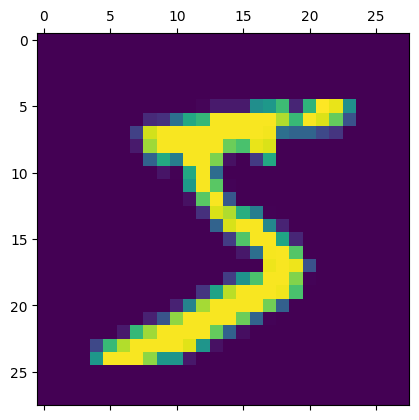

In [9]:
plt.matshow(X_train[0]);

In [10]:
# Scaling the data with the highest possible value in the data
X_train = X_train/255
X_test = X_test/255

In [11]:
# Define the model using the Input layer for the first layer
model = keras.Sequential([
    keras.layers.Input(shape=(28, 28)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

# Print the model summary to verify the structure
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# This will compile the neural network
model.compile(optimizer='adam',  # It allows efficient training
              loss='sparse_categorical_crossentropy', # This is used because the output is categorical. there are other options that can be used
              metrics=['accuracy']
             )

In [14]:
# Buildig the model
model.fit(X_train, y_train, epochs=5) # epochs mean number of iteration the neural network will run the training

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8752 - loss: 0.4450
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9611 - loss: 0.1354
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9715 - loss: 0.0943
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9802 - loss: 0.0654
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9840 - loss: 0.0535


In [16]:
# Evaluatig the accuracy of the model on test dataset
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9708 - loss: 0.0969


[0.08405108749866486, 0.9746999740600586]

In [17]:
# Save the model in the SavedModel format using the new export method
model.export('./saved_model')

Saved artifact at './saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138867518720832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138867518721712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138867518720480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138867518718544: TensorSpec(shape=(), dtype=tf.resource, name=None)


## Post Training Quantization

In [18]:
# Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model('./saved_model')

tflite_model = converter.convert()

W0000 00:00:1731930831.645692      31 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1731930831.645768      31 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


In [19]:
len(tflite_model)

319940

In [20]:
# Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model('./saved_model')

# To quantize the model
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_quant_model = converter.convert()

W0000 00:00:1731930842.530321      31 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1731930842.530355      31 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


In [21]:
len(tflite_quant_model)

84816

In [22]:
# Save the TensorFlow Lite model to a file
with open('tflite_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [23]:
# Save the TensorFlow Lite model to a file
with open('tflite_quant_model.tflite', 'wb') as f:
    f.write(tflite_quant_model)

## Quantization Aware Training

In [25]:
!pip install tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 3.2 MB/s eta 0:00:00a 0:00:01


In [26]:
import tensorflow_model_optimization as tfmot

In [27]:
# Quantization-aware training (QAT)
quantize_model = tfmot.quantization.keras.quantize_model

<center><h2>Functional Model Building</h2></center>

In [38]:
from tensorflow import keras
import tensorflow_model_optimization as tfmot

# Define the model using the Functional API
inputs = keras.Input(shape=(28, 28))
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(100, activation='relu')(x)
outputs = keras.layers.Dense(10, activation='sigmoid')(x)

# Create the functional model
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the original model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Annotate the model for quantization
quantize_annotate_model = tfmot.quantization.keras.quantize_annotate_model
annotated_model = quantize_annotate_model(model)

# Apply quantization-aware training
quantize_apply = tfmot.quantization.keras.quantize_apply
q_aware_model = quantize_apply(annotated_model)

# Compile the quantization-aware model
q_aware_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Print the model summary
q_aware_model.summary()

# Build the model with quantization-aware training
q_aware_model.fit(X_train, y_train, epochs=5)  # epochs mean number of iteration the neural network will run the training

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8772 - loss: 0.4446
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9640 - loss: 0.1255
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9738 - loss: 0.0892
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9825 - loss: 0.0626
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9847 - loss: 0.0519


In [43]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture.
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_split=0.1,
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8442 - loss: 0.5410 - val_accuracy: 0.9653 - val_loss: 0.1182


In [ ]:
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()

In [ ]:
q_aware_model.fit(X_train, y_train, epochs=1)

In [ ]:
# To load the in memory model
converter = tf.file.TFLiteConverer.from_keras_model(q_aware_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

In [ ]:
 # Write the byte to a file
with open('tflte_qaware_model.tflite', 'wb') as f:
    f.write(tflite_qaware_model)